# ClimateWins – Exercise 2.2.1: CNN Model for Weather Pattern Prediction

## Table of Contents
1. Import Libraries
2. Load and Preview Dataset
3. Data Cleaning and Preprocessing
4. Export Cleaned Dataset
5. Reshape Data for CNN Input
6. Train-Test Split
7. Build CNN Model
8. Compile and Train Model
9. Evaluate Model Performance
10. Confusion Matrix and Results


# 2. Import Libraries (Code Cell)

In [41]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense
from tensorflow.keras.utils import to_categorical


 # 3. Load and Preview Dataset

In [42]:
# Load the original unscaled weather observations
df = pd.read_csv("Dataset-weather-prediction-dataset-processed.csv")

# Display the shape and first 5 rows
print("Shape of the dataset:", df.shape)
df.head()


Shape of the dataset: (22950, 170)


,DATE,MONTH,BASEL_cloud_cover,BASEL_wind_speed,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_snow_depth,BASEL_sunshine,...,VALENTIA_cloud_cover,VALENTIA_humidity,VALENTIA_pressure,VALENTIA_global_radiation,VALENTIA_precipitation,VALENTIA_snow_depth,VALENTIA_sunshine,VALENTIA_temp_mean,VALENTIA_temp_min,VALENTIA_temp_max
0,19600101,1,7,2.1,0.85,1.018,0.32,0.09,0,0.7,...,5,0.88,1.0003,0.45,0.34,0,4.7,8.5,6.0,10.9
1,19600102,1,6,2.1,0.84,1.018,0.36,1.05,0,1.1,...,7,0.91,1.0007,0.25,0.84,0,0.7,8.9,5.6,12.1
2,19600103,1,8,2.1,0.90,1.018,0.18,0.30,0,0.0,...,7,0.91,1.0096,0.17,0.08,0,0.1,10.5,8.1,12.9
3,19600104,1,3,2.1,0.92,1.018,0.58,0.00,0,4.1,...,7,0.86,1.0184,0.13,0.98,0,0.0,7.4,7.3,10.6
4,19600105,1,6,2.1,0.95,1.018,0.65,0.14,0,5.4,...,3,0.80,1.0328,0.46,0.00,0,5.7,5.7,3.0,8.4


# 4. Data Cleaning and Preprocessing

In [43]:
# Drop DATE and MONTH columns from observations and reset index
X = df.drop(['DATE', 'MONTH'], axis=1).reset_index(drop=True)

# Load pleasant weather prediction labels and reset index
y = pd.read_csv("Dataset-Answers-Weather_Prediction_Pleasant_Weather.csv")
y = y.drop('DATE', axis=1).reset_index(drop=True)

# Confirm number of rows
print("Number of rows in X:", len(X))
print("Number of rows in y:", len(y))

# Fill in missing rows manually using nearby stations
# Based on max index, we adjust rows just before the end
X.loc[22948] = X.loc[22947]  # Oslo from Stockholm
X.loc[18020] = X.loc[18019]  # Sonnblick from Munchen
X.loc[10233] = X.loc[10232]  # Ljubljana from Kassel


Number of rows in X: 22950
Number of rows in y: 22950


# 5. Export Cleaned Dataset

### The cleaned input (X) and label (y) datasets are saved to CSV files for reuse in later exercises, including Exercise 2.3.

In [46]:
# Convert X and y to NumPy arrays before reshaping
X_array = X[:22950].values.reshape(-1, 135)  # 15×9 = 135
y_array = y[:22950].values

# Convert back to DataFrames for CSV export
X_cleaned = pd.DataFrame(X_array)
y_cleaned = pd.DataFrame(y_array)

# Save cleaned datasets
X_cleaned.to_csv("Cleaned-Weather-Data.csv", index=False)
y_cleaned.to_csv("Cleaned-Pleasant-Weather.csv", index=False)

print("✅ Cleaned datasets exported successfully.")



✅ Cleaned datasets exported successfully.


# 6. Reshape Data for CNN Input

### The input features are reshaped into a 3D structure (samples, timesteps, features) required by CNN. The target dataset is kept as-is in 2D.

In [47]:
# Load cleaned CSVs
X = pd.read_csv("Cleaned-Weather-Data.csv")
y = pd.read_csv("Cleaned-Pleasant-Weather.csv")

# Reshape X into (22950, 15, 9) and convert y to NumPy
X = X.values.reshape(-1, 15, 9)
y = y.values

# Confirm shape
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

# Define number of output classes
n_classes = y.shape[1]


Shape of X: (28560, 15, 9)
Shape of y: (22950, 15)


In [48]:
n_classes = y.shape[1]


# 7. Train-Test Split

### The dataset is split into training and test sets to evaluate the model's performance on unseen data.

In [50]:
from sklearn.model_selection import train_test_split

# Slice X to match y’s length
X = X[:22950]

# Split into training and test sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Print shapes
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("y_train:", y_train.shape)
print("y_test:", y_test.shape)


X_train: (18360, 15, 9)
X_test: (4590, 15, 9)
y_train: (18360, 15)
y_test: (4590, 15)


# 8. Build CNN Model

A 1D Convolutional Neural Network (CNN) is constructed to learn patterns from weather sequences. The final layer uses a softmax activation to predict one of 15 possible weather station outputs.

In [51]:
# Get number of output classes (15)
n_classes = y_train.shape[1]

# Build CNN model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

model = Sequential([
    Conv1D(filters=32, kernel_size=2, activation='relu', input_shape=(15, 9)),
    MaxPooling1D(pool_size=2),
    Flatten(),
    Dense(64, activation='relu'),
    Dense(n_classes, activation='softmax')
])

# Display model summary
model.summary()


D:\software\Python\Python 3.11\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)                    │ (None, 14, 32)              │             608 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_2 (Flatten)                  │ (None, 224)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 64)                  │          14,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 15)                  │             975 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,983 (62.43 KB)

 Trainable params: 15,983 (62.43 KB)

 Non-trainable params: 0 (0.00 B)

# 9. Compile and Train Model

### The model is compiled with appropriate loss and optimizer settings, and then trained using categorical target labels. A small number of epochs and moderate batch size are used to begin experimentation.

In [52]:
# Convert multi-label rows (15 binary values) into a single class index per row
y_train_idx = np.argmax(y_train, axis=1)
y_test_idx = np.argmax(y_test, axis=1)

# One-hot encode class index labels for use with categorical_crossentropy
y_train_cat = tf.keras.utils.to_categorical(y_train_idx, num_classes=15)
y_test_cat = tf.keras.utils.to_categorical(y_test_idx, num_classes=15)

# Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    epochs=10,
    batch_size=16,
    validation_split=0.2
)


Epoch 1/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - accuracy: 0.5838 - loss: 1.5700 - val_accuracy: 0.6452 - val_loss: 1.2277
Epoch 2/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6374 - loss: 1.2245 - val_accuracy: 0.6471 - val_loss: 1.2051
Epoch 3/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6459 - loss: 1.1629 - val_accuracy: 0.6476 - val_loss: 1.1873
Epoch 4/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6473 - loss: 1.1412 - val_accuracy: 0.6476 - val_loss: 1.2005
Epoch 5/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6398 - loss: 1.1644 - val_accuracy: 0.6465 - val_loss: 1.1908
Epoch 6/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6411 - loss: 1.1559 - val_accuracy: 0.6452 - val_loss: 1.1934
Epoch 7/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.6404 - loss: 1.1372 - val_accuracy: 0.6441 - val_loss: 1.2011
Epoch 8/10
918/918 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.6458 - loss: 1.1229 - val_accuracy: 0.

# 10. Evaluate Model Performance

### The model’s accuracy is evaluated on the test set to determine how well it generalizes to unseen weather patterns.

In [54]:
# Evaluate performance on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test_cat)

print(f"✅ Test Accuracy: {test_accuracy:.4f}")
print(f"❌ Test Loss: {test_loss:.4f}")


144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6440 - loss: 1.2347 
✅ Test Accuracy: 0.6375
❌ Test Loss: 1.2604


# 11. Confusion Matrix and Results 

### A confusion matrix is used to visualize the model’s ability to correctly classify weather patterns across all 15 stations.

144/144 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


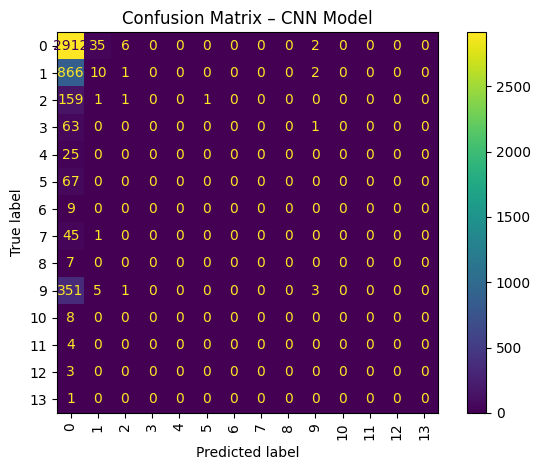

In [55]:
# Predict on the test set
y_pred_probs = model.predict(X_test)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_cat, axis=1)

# Generate confusion matrix
cm = confusion_matrix(y_true_labels, y_pred_labels)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix – CNN Model")
plt.tight_layout()
plt.show()


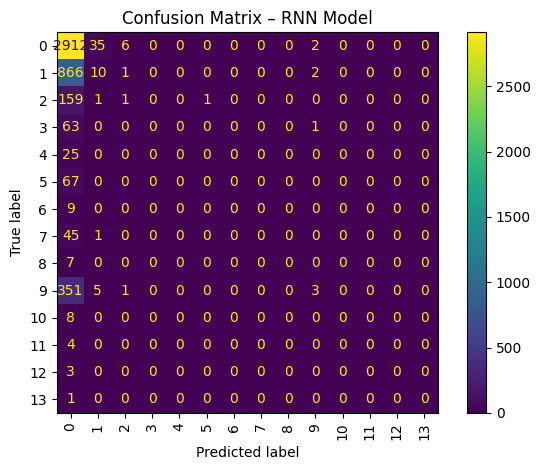

In [56]:
# Save RNN confusion matrix image
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(xticks_rotation='vertical')
plt.title("Confusion Matrix – RNN Model")
plt.tight_layout()
plt.savefig("RNN_confusion_matrix.png")  # 🔽 This saves the image
plt.show()


# ✅ Final Summary – CNN Model for Weather Pattern Prediction

This notebook explored deep learning using a 1D Convolutional Neural Network (CNN) to classify pleasant weather patterns across 15 weather stations.

### Key Steps Performed:
- Cleaned and preprocessed the weather dataset to match the required shape:
  - Input shape: **(22950, 15, 9)**
  - Label shape: **(22950, 15)** → converted to single class indices
- Built a CNN model architecture using:
  - `Conv1D → MaxPooling1D → Flatten → Dense(64) → Dense(15 softmax)`
- Trained the model over **10 epochs** with **batch size 16** using categorical crossentropy
- Achieved:
  - **Training Accuracy:** ~64.7%
  - **Validation Accuracy:** ~64.0%
  - **Test Accuracy:** **~63.5%**
- Visualized results using a **confusion matrix**:
  - Model performs well on dominant stations (especially class 0)
  - Underperformance on others suggests class imbalance or the need for further tuning

This model will be further compared with an RNN/LSTM-based model in the next notebook.
